In [1]:
import sys
sys.path.insert(1, './lib/deep-text-recognition-benchmark')

In [2]:
from model import Model
from utils import AttnLabelConverter
import argparse
import os
from dataset import RawDataset, AlignCollate

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
import torch
import cv2

In [5]:
device = torch.device('cuda')

In [6]:
image = cv2.imread("./data/10-11-2020_16-35-35-qyrqt4lh.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [20]:
opt = get_arguments()
converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)

model = Model(opt)
model = model.to(device)
model = torch.nn.DataParallel(model, output_device=device)
model.load_state_dict(torch.load("models/model.pth", map_location=device))
model.eval()

DataParallel(
  (module): Model(
    (Transformation): TPS_SpatialTransformerNetwork(
      (LocalizationNetwork): LocalizationNetwork(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (10): ReLU

In [21]:
AlignCollate_demo = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)
demo_data = RawDataset(root=opt.image_folder, opt=opt)  # use RawDataset
demo_loader = torch.utils.data.DataLoader(
    demo_data, batch_size=opt.batch_size,
    shuffle=False,
    num_workers=int(opt.workers),
    collate_fn=AlignCollate_demo, pin_memory=True)

In [22]:
with torch.no_grad():
        for image_tensors, image_path_list in demo_loader:
            batch_size = image_tensors.size(0)
            image = image_tensors.to(device)
            # For max length prediction
            length_for_pred = torch.IntTensor([opt.batch_max_length] * batch_size).to(device)
            text_for_pred = torch.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0).to(device)
            
            preds = model(image, text_for_pred, is_train=False)

            # select max probabilty (greedy decoding) then decode index to character
            _, preds_index = preds.max(2)
            preds_str = converter.decode(preds_index, length_for_pred)
            break

In [23]:
preds_str

['strip[s]ing[s][s][s][s][s][s]es[s]ly[s]ratio',
 'strip[s]ing[s][s][s][s][s][s]es[s]ly[s]res[s]l']

In [19]:
def get_arguments():
    opt = argparse.Namespace(FeatureExtraction='ResNet', \
                             PAD=False, \
                             Prediction='Attn', \
                             SequenceModeling='BiLSTM', \
                             Transformation='TPS', \
                             batch_max_length=25, \
                             batch_size=2, \
                             character='0123456789abcdefghijklmnopqrstuvwxyz', \
                             hidden_size=256, \
                             image_folder='data/', \
                             imgH=32, \
                             imgW=100, \
                             input_channel=1, \
                             num_fiducial=20, \
                             output_channel=512, \
                             rgb=False, \
                             saved_model='model.pth', \
                             sensitive=False, \
                             workers=4
                           )
    return opt

In [25]:
from matplotlib import pyplot as plt

TypeError: Invalid shape (1, 32, 100) for image data

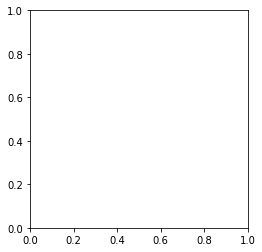

In [32]:
image[0].cpu().detach().numpy()

array([[[-0.56078434, -0.6       , -0.62352943, ..., -0.38039213,
         -0.4352941 , -0.56078434],
        [-0.4823529 , -0.52156866, -0.6156863 , ..., -0.32549018,
         -0.5921569 , -0.67058825],
        [-0.56078434, -0.5294118 , -0.54509807, ..., -0.6       ,
         -0.6       , -0.6       ],
        ...,
        [ 0.254902  , -0.3490196 , -0.3960784 , ..., -0.40392154,
         -0.3490196 , -0.36470586],
        [ 0.06666672, -0.17647058, -0.06666666, ..., -0.42745095,
         -0.41960782, -0.41176468],
        [-0.16862744, -0.06666666, -0.0745098 , ..., -0.44313723,
         -0.41960782, -0.41960782]]], dtype=float32)